In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *
from src.load_data import load_data
import xarray as xr
import pickle
import os
from os import path

import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# parameters

epoch_key = ('jaq', 1, 2) # animal, day, epoch
t1 = 32500 # start time from decode
t2 = 34500 # end time from decode
savefigs = 1 # saves theta, decode, speed and track figures 
data_path = '/home/cwilhite/Src/cameron_alison_theta_decoding/Processed-Data/'
fig_path = '/home/cwilhite/Src/cameron_alison_theta_decoding/figures/' + str(epoch_key[0]) + '_' + str(epoch_key[1]) + '_' + str(epoch_key[2]) + '/'
if savefigs==1:
    if path.exists(fig_path) == False:
        os.mkdir(fig_path)

In [3]:
# load data, decode, get theta, *requires decoding first (needs results.nc and data.pkl)*

results = xr.open_dataset(data_path + 'results_'+ str(epoch_key[0]) + '_' + str(epoch_key[1]) + '_' + str(epoch_key[2]) + '_' + str(t1) + '_' + str(t2) + '.nc') 
data = pickle.load(open(data_path + 'data_' + str(epoch_key[0]) + '_' + str(epoch_key[1]) + '_' + str(epoch_key[2])+ ".pkl", "rb"))
thetabp = data['theta']['bandpassed_lfp']

In [4]:
# due to sampling at diff freqs (decode/pos = 500Hz, theta = 1500 Hz), there is a small offset in the hh:mm:ss times between pos and theta times
# this cell gets decode times in seconds to align theta 

time_start = (data['position_info'][t1:t2].index / np.timedelta64(1, 's'))[0] # sec
time_stop = (data['position_info'][t1:t2].index / np.timedelta64(1, 's'))[-1]
print('pos timestamps (sec)')
print(time_start,',', time_stop)
print('dur:',time_stop-time_start)

ind = np.where(thetabp.index / np.timedelta64(1, 's') < time_start)[0] # samples
ind2 = np.where(thetabp.index / np.timedelta64(1, 's') > time_stop)[0]
theta_ind = ind[-1]
theta_ind2 = ind2[0]
print()
print('theta timestamps (sec)')
print((thetabp.index / np.timedelta64(1, 's'))[theta_ind],',',(thetabp.index / np.timedelta64(1, 's'))[theta_ind2])
print('dur:',(thetabp.index / np.timedelta64(1, 's'))[theta_ind2]- (thetabp.index / np.timedelta64(1, 's'))[theta_ind])

pos timestamps (sec)
2675.546587952 , 2679.544587952
dur: 3.9979999999995925

theta timestamps (sec)
2675.5462 , 2679.544866667
dur: 3.998666666999725


In [5]:
# get theta window and downsample by factor of 3

thetabp_win = thetabp[theta_ind:theta_ind2] 
thetabp_win_ds = thetabp_win[::3] # don't need to downsamp but will help for aligning later?

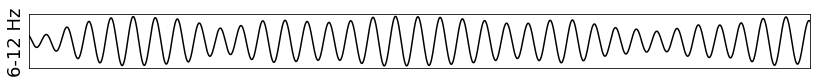

In [6]:
# plot theta

fig, ax = plt.subplots(figsize=(14, 1))
plt.plot(thetabp_win_ds, 'k')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('6-12 Hz',fontsize=18)
ax.set_xticklabels([])
if savefigs==1:
    plt.savefig(fig_path + 'theta_' + str(t1) + '_' + str(t2) + '.png', format='png')

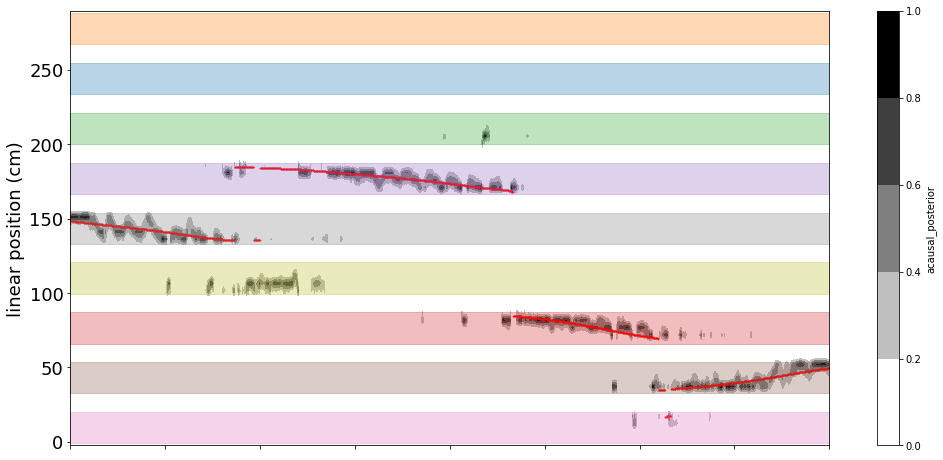

In [7]:
# plot decode

fig, ax = plt.subplots(figsize=(17, 8))
results.acausal_posterior.plot.contourf(x='time', y='position', ax=ax,cmap='binary')
scatter(results.time, data['position_info'][t1:t2].linear_position,c='red',s=.5)
for x, color in enumerate(['tab:orange', 'tab:blue', 'tab:green', 'tab:purple', 'tab:gray', 'tab:olive', 'tab:red', 'tab:brown', 'tab:pink'], start=0):
    fill([0,t2-t1,t2-t1,0], [267-(x*33.5),267-(x*33.5),288-(x*33.5),288-(x*33.5)], color=color, alpha=0.3) # prob not good to hardcode values, but wanted to widen shaded areas for visualization
ax.set_xlim(0,t2-t1)
ax.set_ylabel('linear position (cm)',fontsize=18)
ax.xaxis.label.set_visible(False)
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
yticks(fontsize=18)
if savefigs==1:
    plt.savefig(fig_path + 'decode_' + str(t1) + '_' + str(t2) + '.png', format='png')

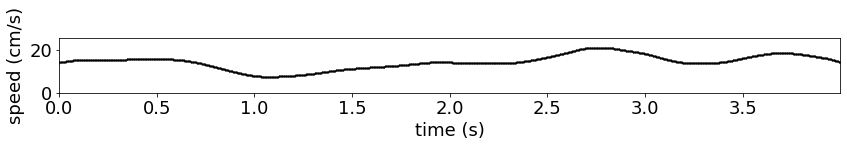

In [8]:
# plot speed

fig, ax = plt.subplots(figsize=(14, 1))
plt.scatter(results.time, data['position_info'][t1:t2].speed,c='black',s=.5)
ax.set_ylabel('speed (cm/s)',fontsize=18)
ax.set_xlabel('time (s)',fontsize=18);
ax.set_ylim(0,max(data['position_info'][t1:t2].speed)*1.2)
plt.autoscale(enable=True, axis='x', tight=True)
labels = np.arange(0, ceil(time_stop-time_start), ceil(time_stop-time_start)/8)
xticks(arange(0, t2-t1, (t2-t1)/8), labels, fontsize=18)
yticks(fontsize=18)
if savefigs==1:
    plt.savefig(fig_path + 'speed_' + str(t1) + '_' + str(t2) + '.png', format='png',bbox_inches = "tight")

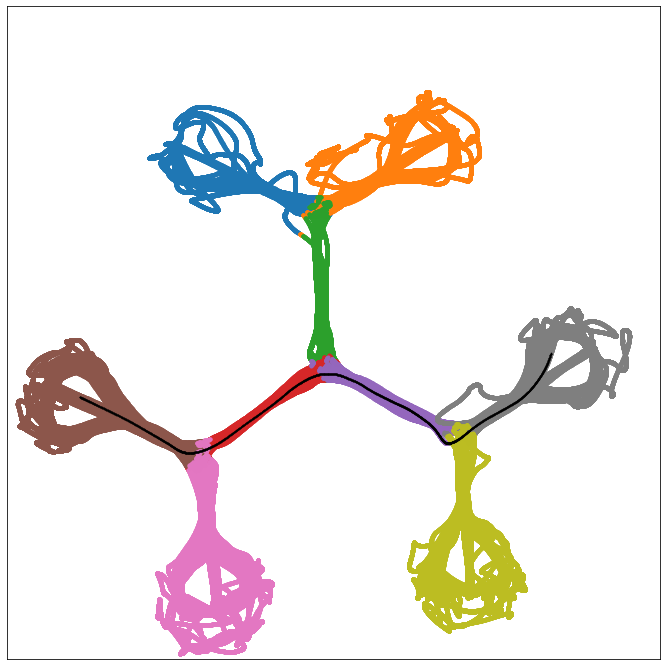

In [9]:
# plot track (overlay of decode traverasl on all pos data)

fig, ax = plt.subplots(figsize=(12, 12))
for edge_label, df in data['position_info'].groupby('track_segment_id'):
    ax.scatter(df.x_position, df.y_position, s=10, alpha=0.9, label=edge_label)
plt.axis('square');
plt.scatter(data['position_info'][t1:t2].x_position, data['position_info'][t1:t2].y_position, color='k',s=.5)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax.set_xlim(0,70)
ax.set_ylim(0,70)
if savefigs==1:
    plt.savefig(fig_path + 'track_' + str(t1) + '_' + str(t2) + '.png', format='png')